## Import libraries and Data

In [1]:
from helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme()

In [2]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

df_coffee = df.loc[df['Product']=='Coffee',['Date','Quantity']].reset_index(drop=True)

del df

In [3]:
split_date = '2023-05-31'

df_train = df_coffee[df_coffee['Date']<=split_date].copy()

## Box Cox Transform Model

In [4]:
scaler_bc = StandardScaler()

In [5]:
df_coffee_bc_scaled = df_train.copy()

df_coffee_bc_scaled['Quantity_BC_Transform'], lam = boxcox(df_coffee_bc_scaled['Quantity'])
df_coffee_bc_scaled['Quantity_BC_Scaled'] = scaler_bc.fit_transform(df_coffee_bc_scaled[['Quantity_BC_Transform']])
df_coffee_bc_scaled['Difference'] = df_coffee_bc_scaled['Quantity_BC_Scaled'].diff()


In [6]:
df_coffee_bc_scaled

,Date,Quantity,Quantity_BC_Transform,Quantity_BC_Scaled,Difference
0,2023-01-01,375,1.267371,-0.572682,NaN
1,2023-01-02,376,1.267397,-0.561042,0.011640
2,2023-01-03,365,1.267105,-0.692201,-0.131159
3,2023-01-04,337,1.266285,-1.060231,-0.368030
4,2023-01-05,346,1.266562,-0.936155,0.124076
...,...,...,...,...,...
146,2023-05-27,747,1.272564,1.758813,-0.020366
147,2023-05-28,689,1.272090,1.545757,-0.213056
148,2023-05-29,550,1.270597,0.875576,-0.670181
149,2023-05-30,617,1.271391,1.232200,0.356623


###  Model Development

In [7]:
aic = []
bic = []
rsquared_adj = []

model_test = df_coffee_bc_scaled.copy()
time_lag(model_test,'Difference',steps=31)
model_test= model_test.dropna()

for step in list(range(30)):
    
    f = []
    for i in list(range(step+1)):
        f.append(f't-{i+1}')

    target = model_test['Difference']
    features = model_test[f]
    features = sm.add_constant(features)

    bc_scaled_mlr_model = sm.OLS(target,features).fit()

    aic.append(bc_scaled_mlr_model.aic)
    bic.append(bc_scaled_mlr_model.bic)
    rsquared_adj.append(bc_scaled_mlr_model.rsquared_adj)


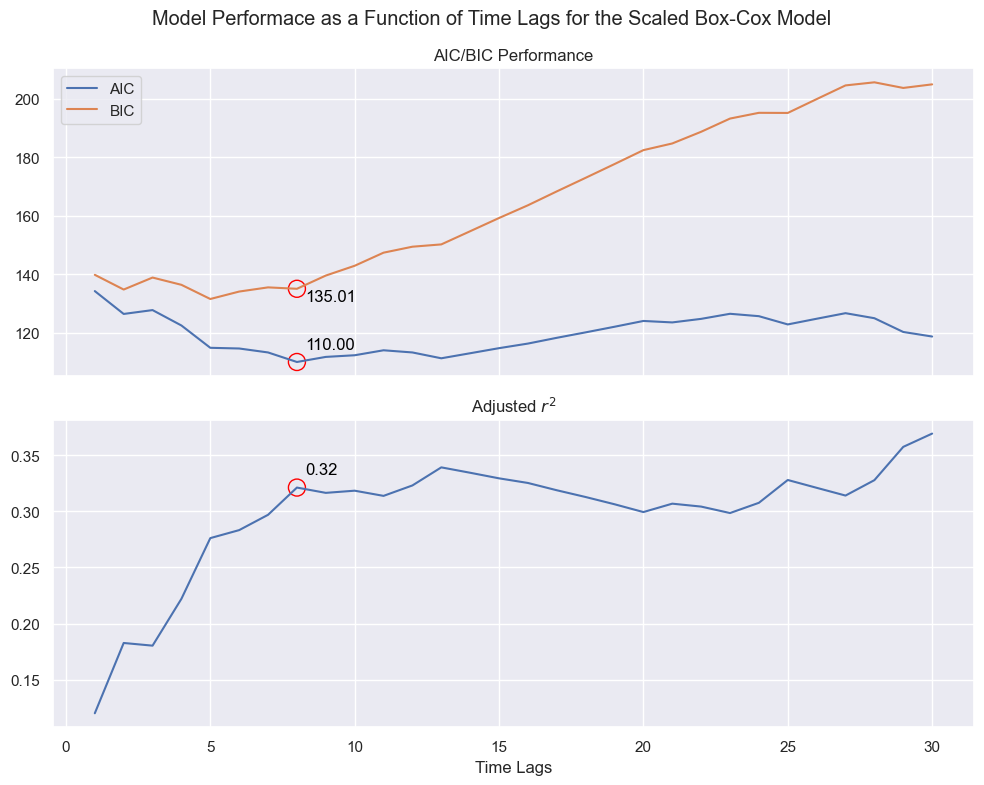

In [40]:
fig, ax = plt.subplots(2,1, figsize = (10,8),sharex=True)

lags = range(1, 31)

sns.lineplot(x= lags, y=aic, ax=ax[0],label='AIC')
sns.lineplot(x=lags, y= bic, ax=ax[0],label='BIC')
sns.lineplot(x=lags, y=rsquared_adj,ax=ax[1])

x_val = 8

y_aic = aic[x_val-1]
y_bic = bic[x_val-1]
y_r2  = rsquared_adj[x_val-1]

ax[0].scatter(x_val, y_aic, s=150, facecolors='none', edgecolors='red', linewidths=1)
ax[0].scatter(x_val, y_bic, s=150, facecolors='none', edgecolors='red', linewidths=1)
ax[1].scatter(x_val, y_r2,  s=150, facecolors='none', edgecolors='red', linewidths=1)

ax[0].text(x_val+0.3, y_aic+4.5, f"{y_aic:.2f}", color='black')
ax[0].text(x_val+0.3, y_bic, f"{y_bic:.2f}", color='black',va='top')
ax[1].text(x_val+0.3, y_r2+0.012,  f"{y_r2:.2f}", color='black')

fig.suptitle("Model Performace as a Function of Time Lags for the Scaled Box-Cox Model")
ax[0].set(title="AIC/BIC Performance")
ax[1].set(title='Adjusted $r^2$',xlabel = "Time Lags")


plt.tight_layout()
plt.savefig("Images/Diagnostics/Model_performance_by_lags.png")

plt.show()

In [9]:
idx = 8

model_df = df_coffee_bc_scaled.copy()
time_lag(model_df,'Difference',steps=idx)
model_df = model_df.dropna()

target = model_df['Difference']

f = []
for i in range(1,8+1):
    f.append(f't-{i}')

features = model_df[f]

features = sm.add_constant(features)

bc_scaled_mlr_model = sm.OLS(target,features).fit()

bc_scaled_mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     9.154
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           5.58e-10
Time:                        16:08:30   Log-Likelihood:                -69.900
No. Observations:                 142   AIC:                             157.8
Df Residuals:                     133   BIC:                             184.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0735      0.035      2.070      0.040       0.003       0.144
t-1           -0.6391      0.084     -7.567      0.000      -0.806      -0.472
t-2           -0.4757      0.097     -4.884      0.000      -0.668      -0.283
t-3           -0.3820      0.104     -3.676      0.000      -0.587      -0.176
t-4           -0.4920      0.101     -4.854      0.000      -0.692      -0.292
t-5           -0.5008      0.101     -4.939      0.000      -0.701      -0.300
t-6           -0.2875      0.104     -2.765      0.007      -0.493      -0.082
t-7           -0.2572      0.099     -2.610      0.010      -0.452      -0.062
t-8           -0.1620      0.085     -1.902      0.059      -0.331       0.006
==============================================================================
Omnibus:                        1.289   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.525   Jarque-Bera (JB):                1.122
Skew:                           0.218   Prob(JB):                        0.571
Kurtosis:                       3.003   Cond. No.                         5.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

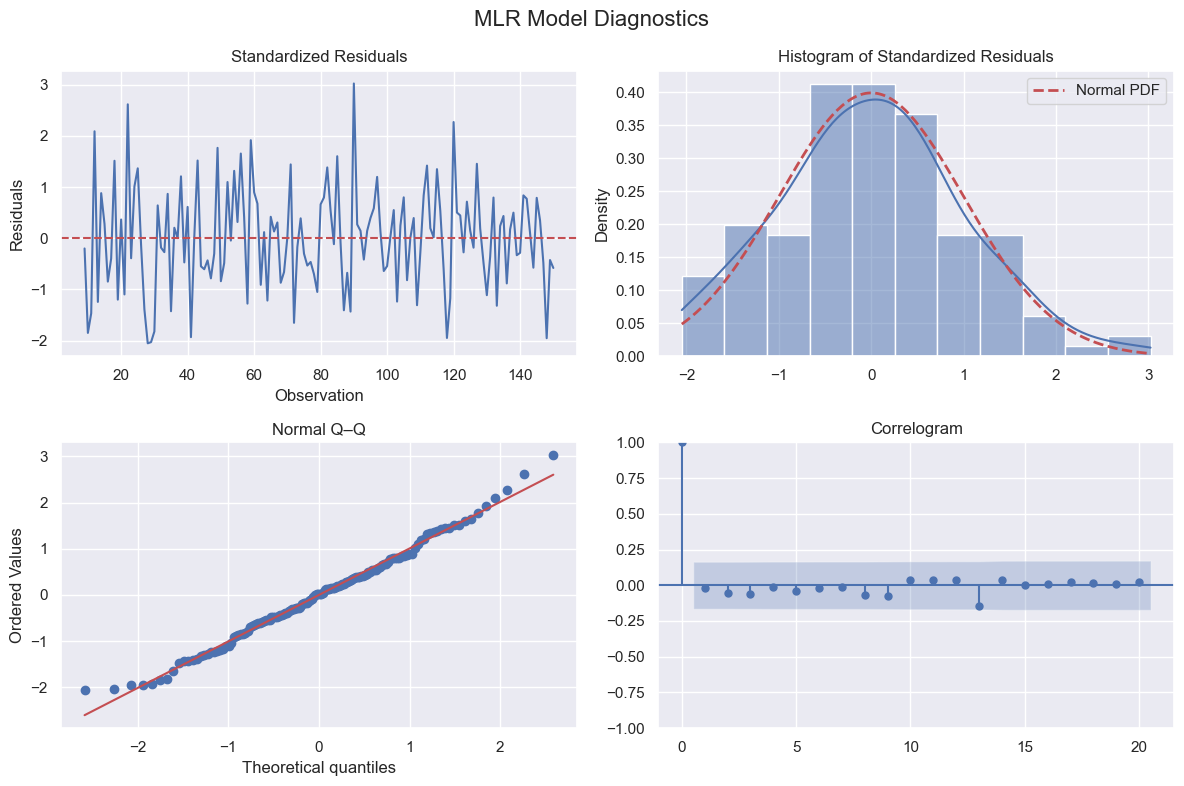

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("MLR Model Diagnostics", fontsize=16)

residuals = bc_scaled_mlr_model.resid
resid_std = (residuals - residuals.mean()) / residuals.std()

#Residuals
axes[0, 0].plot(resid_std, linestyle='-')
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title("Standardized Residuals")
axes[0, 0].set_xlabel("Observation")
axes[0, 0].set_ylabel("Residuals")

#Histogram
sns.histplot(resid_std, kde=True, stat="density", ax=axes[0, 1])

x = np.linspace(resid_std.min(), resid_std.max(), 200)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r--', linewidth=2, label="Normal PDF")
axes[0, 1].legend()
axes[0, 1].set_title("Histogram of Standardized Residuals")

#Q–Q plot
stats.probplot(resid_std, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Normal Q–Q")

#ACF plot
plot_acf(resid_std, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("Correlogram")

plt.tight_layout()

plt.savefig('Images/Diagnostics/MLR_Model_Diagnostics.png')

plt.show()

### Testing

#### One-Step Prediction

In [11]:
df_test = df_coffee.iloc[df_coffee.index[df_coffee['Date'] == split_date][0]-idx:,].copy()
df_test['Quantity_BC_Transform'] = boxcox(df_test['Quantity'],lam)
df_test['Quantity_BC_Scaled'] = scaler_bc.transform(df_test[['Quantity_BC_Transform']])
df_test['Difference'] = df_test['Quantity_BC_Scaled'].diff()

time_lag(df_test,'Difference',steps=idx)

df_test = df_test.dropna()

df_test

,Date,Quantity,Quantity_BC_Transform,Quantity_BC_Scaled,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8
151,2023-06-01,785,1.272841,1.883099,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,-0.211969,-0.014041
152,2023-06-02,713,1.272294,1.637661,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,-0.211969
153,2023-06-03,731,1.272440,1.703051,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477
154,2023-06-04,735,1.272472,1.717194,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366
155,2023-06-05,709,1.272261,1.622729,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056
156,2023-06-06,685,1.272054,1.529883,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181
157,2023-06-07,658,1.271806,1.418251,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623
158,2023-06-08,742,1.272526,1.741618,0.323367,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896
159,2023-06-09,747,1.272564,1.758813,0.017196,0.323367,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795
160,2023-06-10,669,1.271909,1.464699,-0.294114,0.017196,0.323367,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438


In [12]:
predictors = df_test.filter(like='t-')

predictors = sm.add_constant(predictors)

In [13]:
df_test['pred'] = bc_scaled_mlr_model.predict(predictors)

In [14]:
df_test

,Date,Quantity,Quantity_BC_Transform,Quantity_BC_Scaled,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,pred
151,2023-06-01,785,1.272841,1.883099,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,-0.211969,-0.014041,0.276723
152,2023-06-02,713,1.272294,1.637661,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,-0.211969,-0.079870
153,2023-06-03,731,1.272440,1.703051,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,0.098768
154,2023-06-04,735,1.272472,1.717194,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,-0.023761
155,2023-06-05,709,1.272261,1.622729,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.088422
156,2023-06-06,685,1.272054,1.529883,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.094513
157,2023-06-07,658,1.271806,1.418251,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,0.017049
158,2023-06-08,742,1.272526,1.741618,0.323367,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.084825
159,2023-06-09,747,1.272564,1.758813,0.017196,0.323367,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.072674
160,2023-06-10,669,1.271909,1.464699,-0.294114,0.017196,0.323367,-0.111632,-0.092846,-0.094465,0.014143,0.065390,-0.245438,0.063168


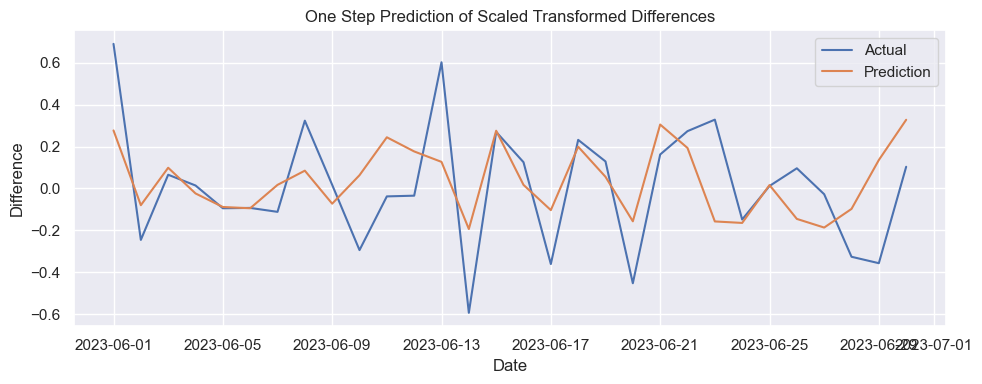

In [41]:
plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test, x='Date', y='Difference',label = 'Actual')
ax = sns.lineplot(data=df_test, x='Date', y='pred', label = 'Prediction')
ax.set(title = "One Step Prediction of Scaled Transformed Differences")

plt.tight_layout()
plt.savefig('Images/Forecasts/Coffee_Single_Step_Differenced.png')

plt.show()

In [16]:
lam

-0.7813454052399581

In [17]:
df_coffee_bc_scaled.tail(5)

,Date,Quantity,Quantity_BC_Transform,Quantity_BC_Scaled,Difference
146,2023-05-27,747,1.272564,1.758813,-0.020366
147,2023-05-28,689,1.272090,1.545757,-0.213056
148,2023-05-29,550,1.270597,0.875576,-0.670181
149,2023-05-30,617,1.271391,1.232200,0.356623
150,2023-05-31,609,1.271305,1.193304,-0.038896


In [18]:
last_value = df_coffee_bc_scaled['Quantity_BC_Scaled'][150]

print(f'Last known value: {last_value:.6f}')

Last known value: 1.193304


In [19]:
df_test_rollup = df_test[['Date', 'Quantity','Quantity_BC_Scaled','Difference','pred']].copy()

#add the differences starting with the last scaled transformed value (5-31-23) -> df_coffee_bc_scaled['Quantity_BC_Scaled'][150]
df_test_rollup['pred_undifferenced'] = df_test_rollup['pred'].cumsum() + last_value

#undo scaling
df_test_rollup['Undifferenced Unscaled'] = scaler_bc.inverse_transform(df_test_rollup[['pred_undifferenced']])

#undo Box-Cox transform
df_test_rollup['Predicted Quantity'] = inv_boxcox(df_test_rollup['Undifferenced Unscaled'], lam)
df_test_rollup = df_test_rollup[['Date','Quantity','Predicted Quantity']]

df_test_rollup


,Date,Quantity,Predicted Quantity
151,2023-06-01,785,670.282682
152,2023-06-02,713,651.501982
153,2023-06-03,731,674.868103
154,2023-06-04,735,669.111864
155,2023-06-05,709,648.439309
156,2023-06-06,685,627.568952
157,2023-06-07,658,631.244526
158,2023-06-08,742,650.116464
159,2023-06-09,747,633.887496
160,2023-06-10,669,647.951794


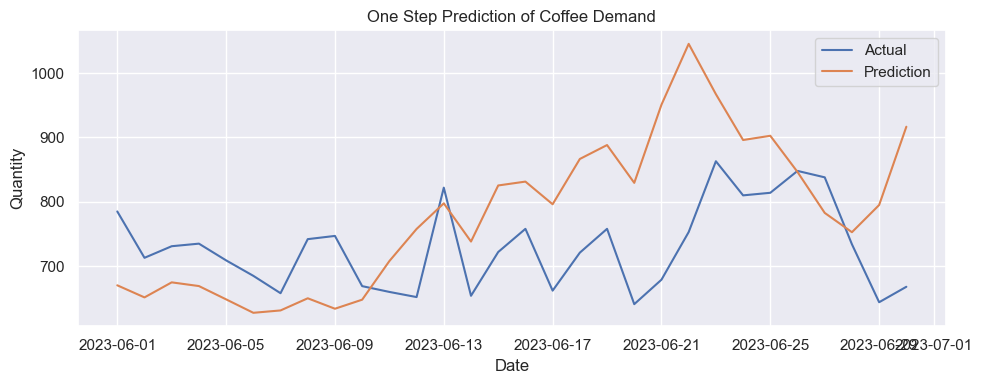

In [42]:
plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test_rollup, x='Date', y='Quantity',label ="Actual")
ax = sns.lineplot(data=df_test_rollup, x='Date', y='Predicted Quantity', label = 'Prediction')
ax.set(title = "One Step Prediction of Coffee Demand")

plt.tight_layout()
plt.savefig('Images/Forecasts/Coffee_Single_Step_Rollup.png')

plt.show()

In [21]:
mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_test_rollup['Predicted Quantity'])*100

print(f'One Step Quantity MAPE: {mape:.2f}%')

One Step Quantity MAPE: 14.15%


### True June Prediction

In [22]:
test_dates = pd.date_range('2023-06-01', '2023-06-30', freq='D')

In [23]:
df_test.head()

,Date,Quantity,Quantity_BC_Transform,Quantity_BC_Scaled,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,pred
151,2023-06-01,785,1.272841,1.883099,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,-0.211969,-0.014041,0.276723
152,2023-06-02,713,1.272294,1.637661,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,-0.211969,-0.079870
153,2023-06-03,731,1.272440,1.703051,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,0.277477,0.098768
154,2023-06-04,735,1.272472,1.717194,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.020366,-0.023761
155,2023-06-05,709,1.272261,1.622729,-0.094465,0.014143,0.065390,-0.245438,0.689795,-0.038896,0.356623,-0.670181,-0.213056,-0.088422


In [24]:

latest_lags = list(df_test.iloc[0][['t-1','t-2','t-3','t-4','t-5','t-6','t-7','t-8']])

lags = [f't-{i}' for i in range(1, 9)]

forecast_diffs = []

for _ in range(len(test_dates)):
    X_new = pd.DataFrame([latest_lags], columns=lags)
    X_new = sm.add_constant(X_new, has_constant='add')
    
    y_pred = bc_scaled_mlr_model.predict(X_new)[0]
    forecast_diffs.append(y_pred)
    
    # Update lag list for next day (push new prediction, drop oldest)
    latest_lags = [y_pred] + latest_lags[:-1]

    

In [25]:
df_forecast = pd.DataFrame({
    'Date': test_dates,
    'Predicted_Difference': forecast_diffs
})

In [26]:
df_forecast
df_forecast['Re-Summed'] = df_forecast['Predicted_Difference'].cumsum() + last_value

df_forecast['Unscaled'] = scaler_bc.inverse_transform(df_forecast[['Re-Summed']])

df_forecast['Predicted Quantity'] = inv_boxcox(df_forecast['Unscaled'],lam)

df_forecast

,Date,Predicted_Difference,Re-Summed,Unscaled,Predicted Quantity
0,2023-06-01,0.276723,1.470027,1.271921,670.282682
1,2023-06-02,0.184145,1.654172,1.272331,717.469929
2,2023-06-03,0.020712,1.674884,1.272377,723.148353
3,2023-06-04,-0.041789,1.633096,1.272284,711.772771
4,2023-06-05,0.007710,1.640806,1.272301,713.847595
5,2023-06-06,-0.120611,1.520195,1.272033,682.579155
6,2023-06-07,-0.066874,1.453321,1.271884,666.275204
7,2023-06-08,0.063042,1.516363,1.272024,681.625732
8,2023-06-09,0.030057,1.546420,1.272091,689.168112
9,2023-06-10,0.082148,1.628568,1.272274,710.559441


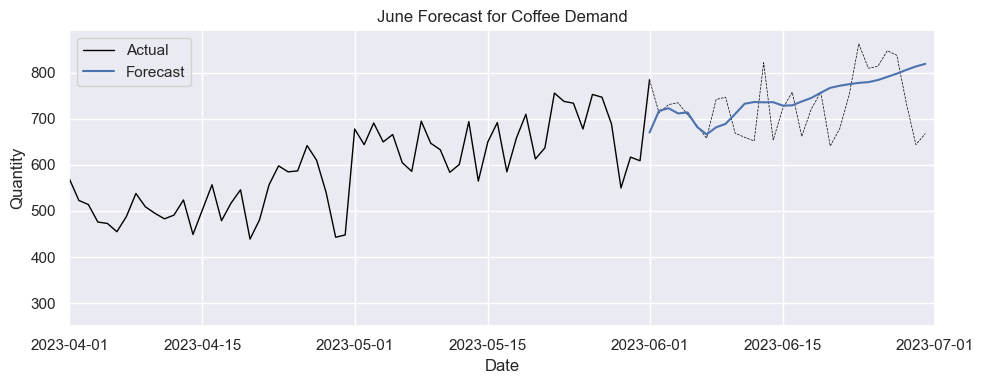

In [43]:
plt.figure(figsize=(10,4))

ax = sns.lineplot(data=df_coffee[df_coffee['Date']<= '2023-06-01'], x='Date',y='Quantity',c='black', label = 'Actual',linewidth = 1)
ax = sns.lineplot(data=df_coffee[df_coffee['Date'] >= '2023-06-01'], x='Date',y='Quantity',c='black',linewidth = 0.5, linestyle = '--')
ax = sns.lineplot(data=df_forecast, x='Date',y='Predicted Quantity',label='Forecast')
#ax = sns.lineplot(data=df_test_rollup, x='Date', y= 'Predicted Quantity', label = 'One-Step Forecast', linestyle = '--')

ax.set(title = "June Forecast for Coffee Demand")
plt.xlim(np.datetime64('2023-04-01'),np.datetime64('2023-07-01'))

plt.tight_layout()
plt.savefig('Images/Forecasts/Coffee_June_Forecast.png')

plt.show()

In [49]:
mape = pd.read_csv('Results/MAPE Scores.csv')
mape

,"Model, MAPE"


In [54]:
forecast_mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_forecast['Predicted Quantity'])*100

print(f'Final Forecast MAPE: {forecast_mape:.2f}%')

Final Forecast MAPE: 7.82%


### July Forecast

In [38]:
coffee_july_forecast = forecast_demand(df_coffee, '2023-07-01','2023-07-31',idx = 8)

coffee_july_forecast.to_csv('Results/coffee_july_forecast.csv')

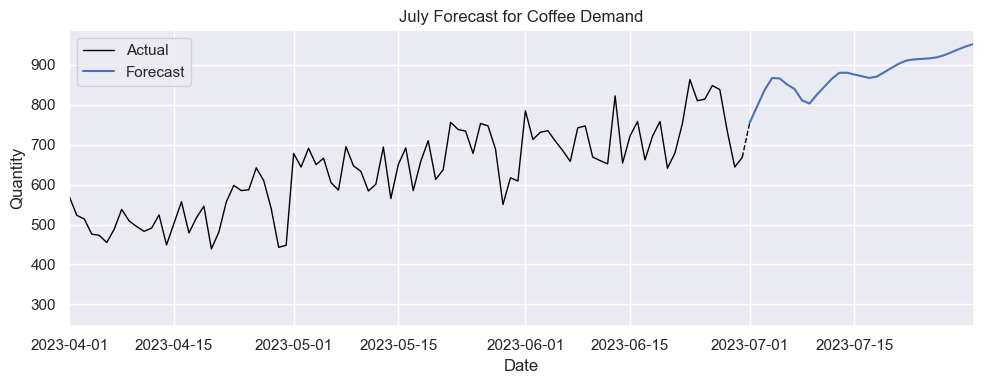

In [ ]:
plt.figure(figsize=(10,4))

bridge_df = pd.DataFrame({'Date':[np.datetime64('2023-06-30'),np.datetime64('2023-07-01')],
                          'Quant':[df_coffee['Quantity'][max(df_coffee.index)],coffee_july_forecast['Predicted Quantity'][0]]})

ax = sns.lineplot(data=df_coffee, x='Date',y='Quantity',c='black', label = 'Actual',linewidth = 1)
ax = sns.lineplot(data=coffee_july_forecast, x='Date',y='Predicted Quantity',label='Forecast')
ax = sns.lineplot(data=bridge_df, x='Date',y='Quant', c='black', linestyle = '--', linewidth =1)

ax.set(title = "July Forecast for Coffee Demand")
plt.xlim(np.datetime64('2023-04-01'),np.datetime64('2023-07-31'))

plt.tight_layout()
plt.savefig('Images/Forecasts/Coffee_July Forecast.png')

plt.show()